<br>실습 : 가상 고객 데이터 KMeans 클러스터링
- 나이/월소득/지출점수/방문빈도/가입기간/최근방문일 같은 간단한 세그먼트 생성
- Elbow + Silhouette로 K 후보 특정 후 KMeans 적용
- 클러스터 프로파일(원래 스케일 평균)까지 요약

(노션 참고를 권장--프로필 아래 링크. 이 소스는 실습용이라 평가부터 엉망진창)

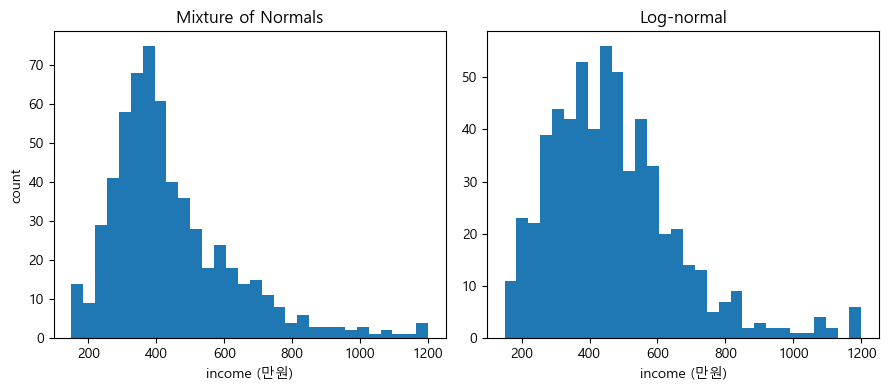

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 600

# 가상 고객 데이터 생성
age = rng.normal(35, 10, n).clip(18, 70)
income_k = rng.choice([1, 2, 3], size=n, p=[0.6, 0.3, 0.1]) # 소득 그룹

# 소득 샘플링
# 1) 혼합 정규분포 (로그정규분포 흉내)
means = {1: 350, 2: 550, 3: 750}
stds = {1: 80, 2: 120, 3: 200}
income_mixnorm = rng.normal([means[k] for k in income_k],
                    [stds[k] for k in income_k], n).clip(150, 1200)
# 2) 로그정규분포
target_mean = 480.0 # 원하는 전체 평균
sigma_log = 0.40 # 0.3 ~ 0.5 정도가 "중간" 꼬리 느낌
mu_log = np.log(target_mean) - 0.5*(sigma_log**2)
income_lognorm = rng.lognormal(mean=mu_log, sigma=sigma_log, size=n).clip(150, 1200)

plt.rc('font', family='Malgun Gothic')

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.hist(income_mixnorm, bins=30)
plt.title("Mixture of Normals")
plt.xlabel("income (만원)"); plt.ylabel("count")

plt.subplot(1,2,2)
plt.hist(income_lognorm, bins=30)
plt.title("Log-normal")
plt.xlabel("income (만원)")

plt.tight_layout()
plt.show()

c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

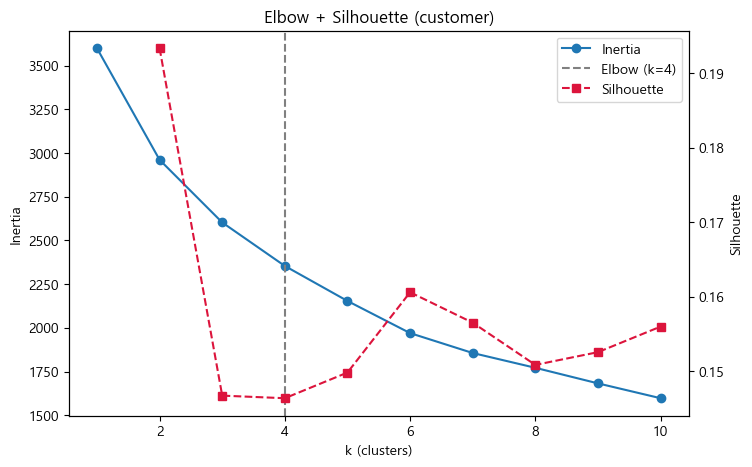

[k 후보] elbow: 4, silhouette: 2


In [65]:
income = income_mixnorm

# 지출 점수(0~100)
# = 소득(높을수록 지출도 높게) + 균일 난수(개인 성향/무작위 요인) + 노이즈 (각 가중치 0.6, 0.3, 0.1)
spend_score = (0.6* (income/income.max()) +
               0.3* rng.random(n) +
               0.1* rng.normal(0.5, 0.2, n)).clip(0, 1) * 100

# 월 방문수 (카운트 데이터 모델링 -> 포아송)
"""
포아송보다 더 분산이 큰(과산포) '음이항분포(Negative Binomial)'이 더 현실성 높음
- 평균 방문수 : mu = 3.0
- 과산포 정도 : alpha = 0.5 (0이면 포아송과 동일)
- n_param = 1 / alpha
- p_param = n_param / (n_param + mu)
visits_nb = rng.negative_binomial(n=n_param, p=p_param, size=n).clip(1, 12)
"""
mu = 3.0 # 월 평균 방문 수
visits_poisson = rng.poisson(mu, n).clip(1, 12)

alpha = 0.5
n_param = 1 / alpha
p_param = n_param / (n_param + mu)
visits_nb = rng.negative_binomial(n=n_param, p=p_param, size=n).clip(1, 12)

visits_m = visits_poisson

# 가입 개월 수 : 고객이 서비스를 얼마나 오래 썼는가 (개월 단위 카운트)
tenure_m = rng.integers(1, 120, n)
# 최근 방문일 : 마지막 방문이 며칠 전인가 (하루 단위 카운트)
recency_d = rng.integers(1, 90, n)

df = pd.DataFrame({
  "age": age,
  "income": income,
  "spend_score": spend_score,
  "visits_per_month": visits_m,
  "tenure_months": tenure_m,
  "recency_days": recency_d
})

# 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Elbow & Silhouette -> k 후보
k_max = 11
inertias = []
sils = []
for k in range(1, k_max):
  km = KMeans(n_clusters=k, n_init=10, random_state=42)
  km.fit(X)
  inertias.append(km.inertia_)
  if k > 1:
    sils.append(silhouette_score(X, km.labels_))
  
knee = KneeLocator(
  list(range(1, k_max)), inertias,
  curve='convex', # Inertia 곡선은 convex
  direction='decreasing' # la
)
elbow_k = knee.knee
sil_k = np.argmax(sils) + 2

fig, ax1 = plt.subplots(figsize=(8,5))

# inertias (Elbow)
ax1.plot(list(range(1, k_max)), inertias, marker='o', label='Inertia')
ax1.set_xlabel("k (clusters)")
ax1.set_ylabel("Inertia")

plt.axvline(elbow_k, linestyle='--', color='gray', label=f'Elbow (k={elbow_k})')

# silhouettes
ax2 = ax1.twinx()
ax2.plot(list(range(2, k_max)), sils, color='crimson', marker='s', linestyle='--', label='Silhouette')
ax2.set_ylabel("Silhouette")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="best")

plt.title("Elbow + Silhouette (customer)")
plt.show()

print(f"[k 후보] elbow: {elbow_k}, silhouette: {sil_k}")

-> k 후보 범위를 4 ~ 6으로 특정

** 노션 참고를 추천(모순 안되게 정리해둠)<br>
** 이 밑은 실습 정리 전, 모순인 상황으로 진행

In [66]:
# 추가 지표
"""
Calinski-Harabasz (CH) 지수
: 클러스터 간 분산은 크고, 클러스터 내 분산은 작을수록 좋다
-> CH 값이 클수록 좋고, 빠르고 안정적이라 실무에 자주 쓰인다
Davies-Bouldin (DB) 지수
: 각 클러스터의 응집도 대비 클러스터와의 분리도
-> DB 값이 작을수록 좋고, 실루엣과 함께 보조지표로 사용된다
"""
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

rows = []
for k in range(2, k_max):
  km = KMeans(n_clusters=k, n_init=10, random_state=42)
  labels = km.fit_predict(X)
  sil = silhouette_score(X, labels)
  ch = calinski_harabasz_score(X, labels)
  db = davies_bouldin_score(X, labels)
  rows.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})

scores_df = pd.DataFrame(rows)
print(scores_df.round(4))

# sil/CH는 높을수록, DB는 낮을수록 좋다

c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

    k  silhouette  calinski_harabasz  davies_bouldin
0   2      0.1934           128.9323          1.8947
1   3      0.1467           114.3070          1.9731
2   4      0.1464           105.1348          1.7604
3   5      0.1498            99.8661          1.6133
4   6      0.1606            98.2971          1.4964
5   7      0.1565            92.8575          1.5194
6   8      0.1508            87.2888          1.5332
7   9      0.1526            84.2036          1.5018
8  10      0.1560            82.1792          1.4790


-> 모순. 해석 불가
- 데이터셋이 완전히 분리된 게 아닌, 연속적인 띠 형태라서,
- 지표 민감도 차이 (실루엣은 거리 계산, CH는 분산 비율, DB는 최대 비율 기반)

In [67]:
# 프로파일링
"""
profile_mean
: 각 클러스터별 특성의 평균값. 해석이 쉽다
profile_median
: 각 클러스터별 특성의 중앙값. 이상치에 덜 민감하여 더 안정적이다.
"""
def fit_and_profile(X_scaled, df_original, k):
  km = KMeans(n_clusters=k, n_init=10, random_state=42)
  labels = km.fit_predict(X_scaled)
  df = df_original.copy()
  df["cluster"] = labels

  prof_mean = df.groupby("cluster").mean(numeric_only=True)
  prof_median = df.groupby("cluster").median(numeric_only=True)
  
  # 프로파일 차이가 뚜렷한지 보기 위해 클러스터 센터를 비교
  # 절댓값이 큰 열이 그 클러스터의 특징
  centers_z = pd.DataFrame(km.cluster_centers_, columns=df_original.columns)

  return df, prof_mean, prof_median, centers_z

for k in [4, 5, 6]:
  df_k, pm, pmed, ct = fit_and_profile(X, df, k)
  print(f"\n=== k={k} : profile_mean ===")
  print(pm.round(2))
  print(f"\n=== k={k} : profile_median ===")
  print(pmed.round(1))
  print(f"\n=== k={k} : 클러스터 센터 ===")
  print(ct.round(2))


=== k=4 : profile_mean ===
           age  income  spend_score  visits_per_month  tenure_months  \
cluster                                                                
0        35.01  748.77        60.28              3.25          58.41   
1        32.52  367.77        37.62              2.83          84.91   
2        31.62  383.74        38.41              2.73          53.54   
3        42.28  399.34        40.31              3.25          26.95   

         recency_days  
cluster                
0               46.79  
1               25.60  
2               69.43  
3               31.22  

=== k=4 : profile_median ===
          age  income  spend_score  visits_per_month  tenure_months  \
cluster                                                               
0        35.5   711.0         56.8               3.0           53.5   
1        31.7   363.6         37.3               3.0           87.5   
2        31.8   367.5         39.3               3.0           52.5   
3        4

c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



=== k=6 : profile_mean ===
           age  income  spend_score  visits_per_month  tenure_months  \
cluster                                                                
0        31.42  429.05        39.89              5.48          61.80   
1        45.68  382.79        38.82              3.09          29.23   
2        30.04  368.52        37.71              2.37          80.99   
3        28.77  435.58        43.13              2.17          25.57   
4        39.01  389.34        38.83              2.39          84.96   
5        34.84  820.15        64.60              3.11          59.22   

         recency_days  
cluster                
0               48.33  
1               29.06  
2               19.74  
3               57.92  
4               66.25  
5               40.88  

=== k=6 : profile_median ===
          age  income  spend_score  visits_per_month  tenure_months  \
cluster                                                               
0        32.0   427.7         4

실무 선택 가이드 (요약)
- 지표 확인: silhouette↑, CH↑, DB↓
- 엘보/실루엣/CH/DB가 가리키는 k 범위를 좁힌 뒤(예: 4~6)
- profile_mean / profile_median으로 해석 가능한지 점검
- 이해되고 활용 가능한 가장 단순한 k를 선택 ✅

해석불가!! 그냥 elbow + silhoutte 통해서 k = 6 선택

선택된 k = 6

[클러스터 평균(원 스케일, inverse transform)]

 age  income  spend_score  visits_per_month  tenure_months  recency_days  cluster
31.4   429.1         39.9               5.5           61.8          48.3        0
45.7   382.8         38.8               3.1           29.2          29.1        1
30.0   368.5         37.7               2.4           81.0          19.7        2
28.8   435.6         43.1               2.2           25.6          57.9        3
39.0   389.3         38.8               2.4           85.0          66.2        4
34.8   820.2         64.6               3.1           59.2          40.9        5

[클러스터별 특성 평균]


c:\Users\dkjjk\anaconda3\envs\ai-dp-ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,age,income,spend_score,visits_per_month,tenure_months,recency_days
cluster,,,,,,
0,31.4,429.1,39.9,5.5,61.8,48.3
1,45.7,382.8,38.8,3.1,29.2,29.1
2,30.0,368.5,37.7,2.4,81.0,19.7
3,28.8,435.6,43.1,2.2,25.6,57.9
4,39.0,389.3,38.8,2.4,85.0,66.2
5,34.8,820.2,64.6,3.1,59.2,40.9



[클러스터별 특성 중앙값]


,age,income,spend_score,visits_per_month,tenure_months,recency_days
cluster,,,,,,
0,32.0,427.7,40.7,5.0,65.0,48.0
1,45.0,374.8,39.3,3.0,25.0,26.0
2,30.5,359.7,37.7,2.0,85.5,19.0
3,28.9,428.9,42.9,2.0,23.0,61.0
4,39.3,367.5,40.1,2.0,87.0,69.0
5,35.7,777.0,62.7,3.0,57.0,39.0


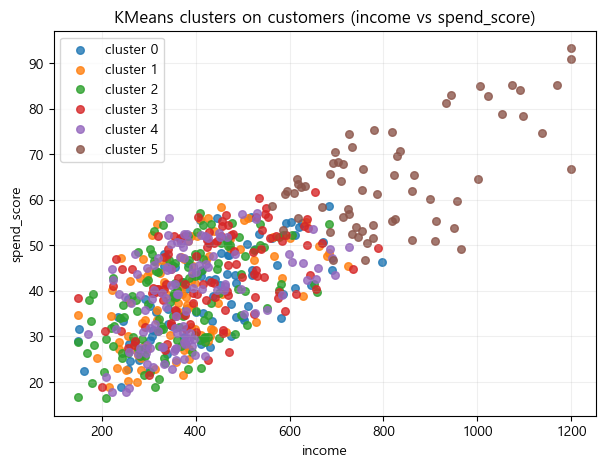

In [73]:
# 최종 K 선택 후 학습
# (실루엣 높거나 눈으로 elbow 지점 선택)

best_k = 6
print(f"선택된 k = {best_k}")

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

# 클러스터 프로파일(원래 스케일로 평균/중앙값)
centers_scaled = kmeans.cluster_centers_
centers_orig = pd.DataFrame(
  scaler.inverse_transform(centers_scaled),
  columns=df.columns[:-1]
)
centers_orig["cluster"] = range(best_k)

profile_mean = df.groupby("cluster").mean(numeric_only=True)
profile_median = df.groupby("cluster").median(numeric_only=True)

print("\n[클러스터 평균(원 스케일, inverse transform)]\n")
# display(centers_orig.round(1).reset_index(drop=True))
print(centers_orig.round(1).to_string(index=False))
print("\n[클러스터별 특성 평균]")
display(profile_mean.round(1))
print("\n[클러스터별 특성 중앙값]")
display(profile_median.round(1))

# 간단 시각화(두 특성으로 투영)
feat_x, feat_y = "income", "spend_score"
plt.figure(figsize=(7,5))
for c in range(best_k):
  m = df["cluster"] == c
  plt.scatter(df.loc[m, feat_x], df.loc[m, feat_y], s=30, alpha=0.8, label=f"cluster {c}")
plt.xlabel(feat_x); plt.ylabel(feat_y)
plt.title(f"KMeans clusters on customers ({feat_x} vs {feat_y})")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

확장
- 프로파일 표 : 각 군집의 평균/중앙값으로 "고소득/고지출", "저소득/저방문", "충성고객(tenure↑, recency↓)" 같은 세그먼트 라벨링
- VIP 집단 라벨링 목적으로 고객 데이터 생성분포를 바꿔서 의도한 세그먼트가 잘 뽑히는 지 확인